Parte 1
===

In [7]:
# !pip install pandas-profiling --user
# !pip install imbalanced-learn==0.10.0 --user

In [139]:
import warnings as ws
ws.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
%matplotlib inline

from pandas_profiling import ProfileReport

from scipy.stats.stats import pearsonr

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [9]:
df = pd.read_csv('data/Usuarios_Reparadora.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [10]:
df.head()

Y Pais  edad     genero          Antiguedad nombre_estado  Tiene_creditos  \
0  0   CO  59.0   FEMENINO    Menos de 6 meses           NaN               1   
1  0   CO  34.0  MASCULINO    Menos de 6 meses           NaN               1   
2  0   CO  33.0  MASCULINO    Menos de 6 meses           NaN               1   
3  0   CO  36.0  MASCULINO    Menos de 6 meses           NaN               1   
4  0   CO  41.0  MASCULINO  de 6 meses a 1 año           NaN               1   

   Creditos  saldo_actual  saldo_vencido  ... Tarjeta_credito_saldo_vencido  \
0         4     1165000.0      1165000.0  ...                           NaN   
1         5    14176000.0     13750000.0  ...                           NaN   
2         3      624000.0       624000.0  ...                           NaN   
3         9     7109000.0      4781000.0  ...                           NaN   
4        15     1737999.0      1688999.0  ...                           NaN   

   %_tarjeta  Tarjeta_pagos_vencidos  Tarjeta_garantia  Vivienda_saldo_actual  \
0        NaN                     NaN               NaN                    NaN   
1        NaN                     NaN               NaN                    NaN   
2        NaN                     NaN               NaN                    NaN   
3        NaN                     NaN               NaN                    NaN   
4        NaN                     NaN               NaN                    NaN   

   Vivienda_saldo_vencido  %_vivienda  Vivienda_pagos_vencidos  \
0                     NaN         NaN                      NaN   
1                     NaN         NaN                      NaN   
2                     NaN         NaN                      NaN   
3                     NaN         NaN                      NaN   
4                     NaN         NaN                      NaN   

   Vivienda_garantia  Garantia  
0                NaN       2.0  
1                NaN       2.0  
2                NaN       2.0  
3                NaN       2.0  
4                NaN       2.0  

[5 rows x 81 columns]

In [11]:
df.tail()

Y Pais  edad     genero          Antiguedad nombre_estado  \
2891  0   CO  30.0   FEMENINO    Menos de 6 meses           NaN   
2892  0   CO  51.0   FEMENINO    Menos de 6 meses           NaN   
2893  0   CO  30.0   FEMENINO    Menos de 6 meses           NaN   
2894  0   CO   NaN   FEMENINO  de 6 meses a 1 año     Santander   
2895  0   CO  22.0  MASCULINO  de 6 meses a 1 año           NaN   

      Tiene_creditos  Creditos  saldo_actual  saldo_vencido  ...  \
2891               1         6      155000.0        60000.0  ...   
2892               1        21     1821000.0      1199000.0  ...   
2893               1         3     1370000.0       831000.0  ...   
2894               1         2     2274000.0      2169000.0  ...   
2895               1         2     3419000.0            0.0  ...   

     Tarjeta_credito_saldo_vencido  %_tarjeta  Tarjeta_pagos_vencidos  \
2891                           NaN        NaN                     NaN   
2892                           NaN        NaN                     NaN   
2893                           NaN        NaN                     NaN   
2894                           NaN        NaN                     NaN   
2895                           0.0        1.0                     0.0   

      Tarjeta_garantia  Vivienda_saldo_actual  Vivienda_saldo_vencido  \
2891               NaN                    NaN                     NaN   
2892               NaN                    NaN                     NaN   
2893               NaN                    NaN                     NaN   
2894               NaN                    NaN                     NaN   
2895               1.0                    NaN                     NaN   

      %_vivienda  Vivienda_pagos_vencidos  Vivienda_garantia  Garantia  
2891         NaN                      NaN                NaN       2.0  
2892         NaN                      NaN                NaN       2.0  
2893         NaN                      NaN                NaN       2.0  
2894         NaN                      NaN                NaN       2.0  
2895         NaN                      NaN                NaN       2.0  

[5 rows x 81 columns]

## 1. Análisis exploratorio de los datos

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 81 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Y                              2896 non-null   int64  
 1   Pais                           2896 non-null   object 
 2   edad                           2718 non-null   float64
 3   genero                         2896 non-null   object 
 4   Antiguedad                     2896 non-null   object 
 5   nombre_estado                  122 non-null    object 
 6   Tiene_creditos                 2896 non-null   int64  
 7   Creditos                       2896 non-null   int64  
 8   saldo_actual                   2893 non-null   float64
 9   saldo_vencido                  2893 non-null   float64
 10  mop_historico                  2721 non-null   object 
 11  numero_pagos_vencidos          1137 non-null   float64
 12  Promedio de limite_credito     1820 non-null   f

El reporte anterior permite identificar campos con porcentajes altos de valores nulos tales como: *nombre_estado*, *%_educuacion* y *%_vivienda*. Posiblemente sean eliminados del conjunto de datos de entrenamiento, ya que por insuficiencia de datos, probablemente no aportan valor; sin embargo, esa decisión se tomará luego de explorar la información.

In [13]:
# df[df.saldo_actual>4500000]

In [14]:
profile = ProfileReport(df, title="Perfilamiento Usuarios Reparadora", minimal=True)

In [15]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

En términos generales, se encontraron **81 características** en el conjunto de datos, sumando la variable objetivo "Y". Un total de **7 categóricas** y **74 numéricas**. Tenemos **2896 observaciones** con un porcentaje de 56.4% valores nulos y un tamaño promedio por registro de 648 bytes. A cotinuación, realizaremos un resumen del análisis exploratorio a partir del reporte generado con *pandas-profiling*, detallando las características y estadísticos más relevantes de las variables individuales.

### Variable objetivo:

Puede notarse que la variable objetivo, la cual evalúa la propensión de un usuario a ser aceptado (1) o rechazado (0) por la compañía reparadora de deudas, tiene un notable desbalance en los datos. **97.1%** de los usuarios han sido rechazados, lo cual puede deberse a que las políticas de ingreso son muy exigentes con respecto a los score y/o condiciones financieras del crédito. Cualquiera que sea la explicación, nos deja solo un **2.9%** de los usuarios como propensos a reparación y un conjunto de datos bastante desbalanceado para el propósito de modelado. Más adelante se analizaran las alternativas para balanceo de la muestra o se eligiran modelos tolerantes a estas condiciones.

### Variables con valor constante:

Tienen un único valor constante y por tanto, no aportan mucho valor a la hora del modelo. De todas formas, se tendrán en cuenta para analizar el conjunto de datos con observaciones nuevas en el proceso predictivo, ya que pueden surgir nuevos valores no vistos en el entrenamiento. Igualmente, haremos un repaso de cada una para verificar si tienen valores nulos, ya que la interpretación de este puede derivar en un valor por defecto que complemente el conjunto de datos.

| Columna                   | Constante | % nulos | # nulos |
|:--------------------------|:----------|:--------|:--------|
| Pais                      | CO        | 0.0%    | 0       |
| Tiene_creditos            | 1         | 0.0%    | 0       |
| sistema_operativo         | ANDROID   | 64.1%   | 1857    |
| Tiene_seguros             | 0         | 0.0%    | 0       |
| Seguros                   | 0         | 0.0%    | 0       |
| Activos_garantia          | 1.0       | 91.3%   | 2644    |
| Autos_garantia            | 1.0       | 99.5%   | 2881    |
| Comunicaciones_garantia   | 1.0       | 21.2%   | 614     |
| consumo_garantia          | 1.0       | 37.1%   | 1074    |
| Educacion_garantia        | 1.0       | 98.8%   | 2861    |
| Libranza_pagos_vencidos   | 0.0       | 99.9%   | 2894    |
| Libranza_garantia         | 1.0       | 99.7%   | 2887    |
| microcredito_garantia     | 1.0       | 93.1%   | 2695    |
| Otros_garantia            | 1.0       | 87.3%   | 2529    |
| Tarjeta_garantia          | 1.0       | 97.6%   | 2826    |
| Vivienda_saldo_vencido    | 0.0       | 99.8%   | 2891    |
| Vivienda_pagos_vencidos   | 0.0       | 99.9%   | 2895    |
| Vivienda_garantia         | 1.0       | 99.8%   | 2891    |

#### Variables no consideradas para el modelado:

- Pais: si todos los usuarios son de Colombia, no aporta mucho valor en el modelado.
- Tiene_creditos: en este caso se descarta, ya que no impacta modelado, en teoria todos los usuarios tienen algún producto, no se están evaluando usuarios que no reportan productos.
- Tiene_seguros: este valor no aportará en modelado, ya que ningún usuario tiene seguros.
- Seguros: este valor no aportará en modelado, ya que ningún usuario tiene seguros.
- Libranza_pagos_vencidos: aunque tiene gran proporcioón de valores nulos, los cuales se imputarían con un cero, el valor igualmente se vuelve único y por tanto aplica para descartarlo.
- Vivienda_saldo_vencido: aplica la misma regla anterior.
- Vivienda_pagos_vencidos: aplica la misma regla anterior.

#### Completar con valores por defecto:

- sistema_operativo: solo se reporta el valor ANDROID y el resto de usuarios nulos. Rellenar con un valor por defecto: OTRO.

**NOTA:** El resto de variables se analizaran más adelante, ya que tienen una consideración especial de validación en bloque. Son las que en el nombre finalizan con "..._garantia". Estas tendrán un valor por defecto que es cero (0) y por tanto, saldrán de esta categoria.

### Variables categóricas no balanceadas:

Son variables categóricas que tienen uno o varios valores que producen un desbalance en la muestra de datos. Se debe estudiar en este caso las categorías con pocos valores, ya que podrían integrarse con otras y evaluar si es necesario calcular una nueva variable. Es importante tener claro el impacto de estos desbalances durante el entrenamiento, ya que pueden producir sesgos en el modelado.

| Columna                   | % desbalance | % nulos | # nulos |
|:--------------------------|:-------------|:--------|:--------|
| Antiguedad                | 55.4%        | 0.0%    | 0       |
| mop_historico             | 71.2%        | 6.0%    | 175     |

- Notamos el valor *Menos de 6 meses (82.6%)* es el que tiene la mayoría de los registros en la columna **Antiguedad**. Y el valor *mas de 1 año (0.7%)* tiene un porcentaje muy bajo. Esto puede indicar una estratificación en los datos que marca diferencias sustanciales al entrenar y posiblemente el algoritmo sea menos robusto para el valor con menos datos. En la fase de ingeniería de características analizaremos más a fondo esta situación, aunque como primera medida podríamos pensar en unir las dos categorías más pequeñas de esta variable.
- En cuanto la variable **mop_historico**, notamos que tiene valores enteros y un alfanumérico (N: deuda al día). Más adelante será construída una nueva variable para el nivel mop historico de tipo categórica. Los valores nulos serán llenados más adelante con una valor categórico: "Sin registro".

### Variables con sesgo alto:

Corresponden a aquellas con una considerable asimetría que da cabida a que tenga valores atípicos. Estas variables se deben estudiar un poco mejor, con el fin de identificar valores que quizas tengan errores o por el contrario, expliquen un comportamiento no frecuente o con anomalías.

| Columna                      | Coef. sesgo  | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Promedio de credito_maximo   | 23.8741651   | 0.3%    | 8       |
| monto_ahorro                 | 50.9591504   | 0.0%    | 0       |
| monto_bloqueado              | 19.9071715   | 2.0%    | 58      |
| monto_total                  | 22.6801084   | 2.0%    | 58      |

- El **Promedio de credito_maximo** tiene un total de 359 registros con valor menos uno (-1) y 428 con valor cero (0). Los valores negativos se deben llevar a cero (0). Se continúa considerando para el modelado.
- Con respecto al **monto_ahorro** notamos que la mayoría de los valores son ceros (97% de los registros), lo cual causa el alto sesgo encontrado, ya que tiene un valor máximo de $8.000.000. A pesar de esta situación, se conserva la variable para el modelado ya que los valores en cero implica que las personas captadas no tienen ahorros.
- Con el **monto_bloqueado** y **monto_total** ocurre una situación similar a la anterior, donde se encuentra que el 97.2% de los registros tienen valor cero (0). Por lo tanto, se replica la misma conclusión. Los valores nulos serán llenados con ceros.

### Variables con valor "cero":

| Columna                      | # zeros      | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| saldo_actual                 | 65 (2.2%)    | 0.1%    | 3       |
| saldo_vencido                | 230 (7.9%)   | 0.1%    | 3       |
| Promedio de valor_cuota      | 274 (9.5%)   | 0.1%    | 3       |
| ahorro_impacto               | 2860 (98.8%) | 0.1%    | 2       |
| bienestar_financiero_impacto | 2891 (99.8%) | 0.1%    | 2       |
| coaching_impacto             | 2838 (98.0%) | 0.1%    | 2       |
| gestion_de_gastos_impacto    | 2894 (99.9%) | 0.1%    | 2       |
| Tiene_ahorro                 | 2809 (97.0%) | 0.0%    | 0       |

**NOTA:** Con estas variables únicamente se considera imputar valores nulos y negativos como cero (0), excepto con **gestion_de_gastos_impacto** ya que al imputar nulos con cero (0) queda como variable con único valor, por lo tanto esta será eliminada.

### Variables con valores nulos:

Corresponde a las variables que tienen algún porcentaje de valores nulos. En este caso, se identifica un valor por defecto o son columnas que a descartar para el modelado. En algunos casos se podrán construir características con base en variables relacionadas o usando las medidas de tendencia central para complentarlos.

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| edad                         | entero       | 6.1%    | 178     |
| nombre_estado                | categórica   | 95.8%   | 2774    |
| numero_pagos_vencidos        | entero       | 60.7%   | 1759    |
| Promedio de cantidad_cuotas  | flotante     | 10.3%   | 297     |
| score                        | entero       | 8.4%    | 244     |
| perfil_usuario               | entero       | 8.4%    | 244     |
| Desinstalaciones             | entero       | 64.1%   | 1857    |


#### Variables no consideradas para el modelado:

- nombre_estado: es una variable categórica que representa el departamento al que pertenece el usuario. Tiene 22 valores únicos y una proporción del 95.8% de valores nulos. Dado que no es posible inferirlo desde otra fuente de datos, se descarta para el modelado.
- perfil_usuario: esta variable esta relacionada con el *score*, por tanto, será descartada del conjunto de datos y calculada como categórica más adelante.

#### Completar con medidas de tendencia central:

- edad: utilizaremos la **media**, ya que tiene una distribución "cercana" a una normal y el sesgo, aunque es positivo, es un valor pequeño, al igual que la curtosis.

#### Completar con valores por defecto:

- score: esta métrica viene de un sistema externo, por lo tanto, los usuarios que no cuentan con este valor se dejaran tal cual. Más adelante se creará una nueva variable para perfil de usuario con base en los rangos del score en DataCrédito, sustituyendo en este caso los nulos por valor: "Sin registro".
- Desinstalaciones: los valores nulos se completaran con ceros, dado que para quienes no tienen este registro significa que aún no han hecho desinstalaciones.
- numero_pagos_vencidos: los valores nulos y negativos se llenan con cero (0)
- Promedio de cantidad_cuotas: los valores nulos y negativos se llenan con cero (0)

In [16]:
# types_df = pd.DataFrame(df.dtypes, columns=['type']).reset_index()
# types_df['type'] = [str(i) for i in types_df.type.tolist()]
# types_df[types_df.type.isin(['int64', 'float64'])]['index'].tolist()

In [17]:
# types_df[types_df.type.isin(['object'])]['index'].tolist()

### Variables analizadas en bloque:

Son variables que se interpretan por categorizarse en bloque o grupo y básicamente lo que se intuye es que **definen la existencia de un producto** en el portafolio de los clientes, en caso que no se cuente con los datos se asume por tanto que el usuario no tiene ese producto o servicio. Hay un alto porcentaje de valores nulos y algunos tienen valores negativos, para este caso se imputará con cero (0). Algunas variables serán eliminadas dado que tienen un valor único: 'Libranza_pagos_vencidos', 'Vivienda_saldo_vencido' y 'Vivienda_pagos_vencidos'.

> **Bloque Valores de Activos**
> - Activo_saldo_actual has 2656 (91.7%) missing values
> - Activo_saldo_vencido has 2656 (91.7%) missing values
> - %_Activo has 2666 (92.1%) missing values
> - Activos_pagos_vencidos has 2809 (97.0%) missing values
> - Activos_garantia has 2644 (91.3%) missing values

> **Bloque Valores de Autos**
> - Autos_saldo_actual has 2882 (99.5%) missing values	
> - Autos_saldo_vencido has 2882 (99.5%) missing values	
> - %_Autos has 2882 (99.5%) missing values	
> - Autos_pagos_vencidos has 2888 (99.7%) missing values	
> - Autos_garantia has 2881 (99.5%) missing values	

> **Bloque Valores de Comunicaciones**
> - Comunicaciones_saldo_actual has 632 (21.8%) missing values	
> - Comunicaciones_saldo_vencido has 632 (21.8%) missing values	
> - %_comunicaciones has 680 (23.5%) missing values	
> - Comunicaciones_pagos_vencidos has 2005 (69.2%) missing values	
> - Comunicaciones_garantia has 614 (21.2%) missing values	

> **Bloque Valores de Consumo**
> - Consumo_saldo_actual has 1098 (37.9%) missing values	
> - Consumo_saldo_vencido has 1098 (37.9%) missing values	
> - %_consumo has 1120 (38.7%) missing values	
> - consumo_pagos_vencidos has 2258 (78.0%) missing values	
> - consumo_garantia has 1074 (37.1%) missing values	

> **Bloque Valores de Educación**
> - Educacion_saldo_actual has 2861 (98.8%) missing values	
> - Educacion_saldo_vencido has 2861 (98.8%) missing values	
> - %_educuacion has 2861 (98.8%) missing values	
> - Educacion_pagos_vencidos has 2883 (99.6%) missing values	
> - Educacion_garantia has 2861 (98.8%) missing values	

> **Bloque Valores de Libranza**
> - Libranza_saldo_actual has 2887 (99.7%) missing values	
> - Libranza_saldo_vencido has 2887 (99.7%) missing values	
> - %_libranza has 2887 (99.7%) missing values	
> - Libranza_pagos_vencidos has 2894 (99.9%) missing values	
> - Libranza_garantia has 2887 (99.7%) missing values	

> **Bloque Valores de Microcrédito**
> - Microcredito_saldo_actual has 2710 (93.6%) missing values	
> - Microcredito_saldo_vencido has 2710 (93.6%) missing values	
> - %_microcredito has 2718 (93.9%) missing values	
> - microcredito_pagos_vencidos has 2832 (97.8%) missing values	
> - microcredito_garantia has 2695 (93.1%) missing values	

> **Bloque Valores de Otros Productos**
> - Otros_saldo_actual has 2539 (87.7%) missing values	
> - Otros_saldo_vencido has 2539 (87.7%) missing values	
> - %_otro has 2542 (87.8%) missing values	
> - Otros_pagos_vencidos has 2761 (95.3%) missing values
> - Otros_garantia has 2529 (87.3%) missing values	

> **Bloque Valores de Tarjeta Crédito**
> - Tarjeta_credito_saldo_actual has 2405 (83.0%) missing values
> - Tarjeta_credito_saldo_vencido has 2405 (83.0%) missing values
> - %_tarjeta has 2409 (83.2%) missing values	
> - Tarjeta_pagos_vencidos has 2832 (97.8%) missing values
> - Tarjeta_garantia has 2826 (97.6%) missing values

> **Bloque Valores de Vivienda**
> - Vivienda_saldo_actual has 2891 (99.8%) missing values
> - Vivienda_saldo_vencido has 2891 (99.8%) missing values
> - %_vivienda has 2891 (99.8%) missing values
> - Vivienda_pagos_vencidos has 2895 (> 99.9%) missing values
> - Vivienda_garantia has 2891 (99.8%) missing values

In [18]:
# block_columns = ['Activo_saldo_actual', 'Activo_saldo_vencido', '%_Activo', 'Activos_pagos_vencidos', 'Activos_garantia']
# df[~df['%_Activo'].isna()][block_columns]

##  2. Ingeniería de características

In [19]:
columns_to_remove = [
    'Pais', 'nombre_estado', 'perfil_usuario', 'gestion_de_gastos_impacto', 'Tiene_creditos', 'Tiene_seguros', 'Seguros', 
    'Libranza_pagos_vencidos', 'Vivienda_saldo_vencido', 'Vivienda_pagos_vencidos', 
]

columns_with_negatives = [
    'saldo_actual', 'saldo_vencido', 'numero_pagos_vencidos', 'Promedio de limite_credito', 'Promedio de credito_maximo',
    'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'Activo_saldo_actual', 'Activo_saldo_vencido', '%_Activo',
    'Comunicaciones_saldo_actual', 'Comunicaciones_saldo_vencido', '%_comunicaciones', 'Comunicaciones_pagos_vencidos',
    'Consumo_saldo_actual', 'Consumo_saldo_vencido', '%_consumo', 'consumo_pagos_vencidos', 'Educacion_saldo_actual', 
    'Educacion_saldo_vencido', '%_educuacion', 'Microcredito_saldo_actual', 'Microcredito_saldo_vencido', '%_microcredito',
    'Otros_pagos_vencidos',
]

columns_to_fill_with_zero = [
    'saldo_actual', 'saldo_vencido', 'numero_pagos_vencidos', 'Promedio de limite_credito', 'Promedio de credito_maximo',
    'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'Desinstalaciones', 'monto_bloqueado', 'monto_total',
    'Activo_saldo_actual', 'Activo_saldo_vencido', '%_Activo', 'Activos_pagos_vencidos', 'Activos_garantia', 
    'Autos_saldo_actual', 'Autos_saldo_vencido', '%_Autos', 'Autos_pagos_vencidos', 'Autos_garantia',
    'Comunicaciones_saldo_actual', 'Comunicaciones_saldo_vencido', '%_comunicaciones', 'Comunicaciones_pagos_vencidos', 
    'Comunicaciones_garantia', 'Consumo_saldo_actual', 'Consumo_saldo_vencido', '%_consumo', 'consumo_pagos_vencidos', 
    'consumo_garantia', 'Educacion_saldo_actual', 'Educacion_saldo_vencido', '%_educuacion', 'Educacion_pagos_vencidos', 
    'Educacion_garantia', 'Libranza_saldo_actual', 'Libranza_saldo_vencido', '%_libranza', 'Libranza_garantia',
    'Microcredito_saldo_actual', 'Microcredito_saldo_vencido', '%_microcredito', 'microcredito_pagos_vencidos', 
    'microcredito_garantia', 'Otros_saldo_actual', 'Otros_saldo_vencido', '%_otro', 'Otros_pagos_vencidos', 'Otros_garantia',
    'Tarjeta_credito_saldo_actual', 'Tarjeta_credito_saldo_vencido', '%_tarjeta', 'Tarjeta_pagos_vencidos', 'Tarjeta_garantia',
    'Vivienda_saldo_actual', '%_vivienda', 'Vivienda_garantia', 
    'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto',
]

In [20]:
target_column = ['Y']

categorical_columns = [
    'genero', 'rango_edad', 'Antiguedad', 'mop_historico', 'perfil_usuario', 'sistema_operativo', 'Garantia'
]

numerical_columns = [
    'Creditos', 'saldo_actual', 'saldo_vencido', 'numero_pagos_vencidos', 'Promedio de limite_credito', 
    'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'ahorro_impacto',
    'bienestar_financiero_impacto', 'coaching_impacto', 'Desinstalaciones', 'Tiene_ahorro', 'monto_ahorro',
    'monto_bloqueado', 'monto_total',
]

numerical_groups_columns = [
    ['Activo_saldo_actual', 'Activo_saldo_vencido', '%_Activo', 'Activos_pagos_vencidos', 'Activos_garantia'],
    ['Autos_saldo_actual', 'Autos_saldo_vencido', '%_Autos', 'Autos_pagos_vencidos', 'Autos_garantia'],
    ['Comunicaciones_saldo_actual', 'Comunicaciones_saldo_vencido', '%_comunicaciones', 'Comunicaciones_pagos_vencidos', 'Comunicaciones_garantia'],
    ['Consumo_saldo_actual', 'Consumo_saldo_vencido', '%_consumo', 'consumo_pagos_vencidos', 'consumo_garantia'],
    ['Educacion_saldo_actual', 'Educacion_saldo_vencido', '%_educuacion', 'Educacion_pagos_vencidos', 'Educacion_garantia'],
    ['Libranza_saldo_actual', 'Libranza_saldo_vencido', '%_libranza', 'Libranza_garantia'],
    ['Microcredito_saldo_actual', 'Microcredito_saldo_vencido', '%_microcredito', 'microcredito_pagos_vencidos', 'microcredito_garantia'],
    ['Otros_saldo_actual', 'Otros_saldo_vencido', '%_otro', 'Otros_pagos_vencidos', 'Otros_garantia'],
    ['Tarjeta_credito_saldo_actual', 'Tarjeta_credito_saldo_vencido', '%_tarjeta', 'Tarjeta_pagos_vencidos', 'Tarjeta_garantia'],
    ['Vivienda_saldo_actual', '%_vivienda', 'Vivienda_garantia']
]

numerical_all_columns = numerical_columns + [j for i in numerical_groups_columns for j in i]

### Limpieza de los datos

In [21]:
clean_df = df.copy()

In [22]:
# Eliminamos las características que no serán requeridas
clean_df = clean_df.drop(columns=columns_to_remove)

In [23]:
# Reemplazamos valores negativos en características numéricas por NULO
# y luego los valores nulos por cero (0)

for column in columns_with_negatives:
    clean_df[column] = clean_df[column].apply(lambda x: np.nan if x < 0 else x)
    
for column in columns_to_fill_with_zero:
    clean_df[column] = clean_df[column].fillna(0)

In [24]:
clean_df[columns_to_fill_with_zero].describe().transpose()

count          mean           std  min  \
saldo_actual                   2896.0  2.932009e+06  8.291932e+06  0.0   
saldo_vencido                  2896.0  1.735882e+06  6.784136e+06  0.0   
numero_pagos_vencidos          2896.0  6.338743e+00  4.406009e+01  0.0   
Promedio de limite_credito     2896.0  7.172759e+04  3.410693e+05  0.0   
Promedio de credito_maximo     2896.0  5.452882e+05  1.847657e+06  0.0   
Promedio de cantidad_cuotas    2896.0  7.277507e+00  1.569953e+01  0.0   
Promedio de valor_cuota        2896.0  2.155279e+05  8.545303e+05  0.0   
Desinstalaciones               2896.0  4.337017e-01  8.078353e-01  0.0   
monto_bloqueado                2896.0  6.134908e+02  8.953317e+03  0.0   
monto_total                    2896.0  8.472290e+02  1.327552e+04  0.0   
Activo_saldo_actual            2896.0  5.119855e+04  3.209236e+05  0.0   
Activo_saldo_vencido           2896.0  4.038570e+04  2.771464e+05  0.0   
%_Activo                       2896.0  3.905665e-02  1.763484e-01  0.0   
Activos_pagos_vencidos         2896.0  7.389503e-02  9.345021e-01  0.0   
Activos_garantia               2896.0  8.701657e-02  2.819080e-01  0.0   
Autos_saldo_actual             2896.0  3.808046e+04  8.668158e+05  0.0   
Autos_saldo_vencido            2896.0  9.065608e+03  2.096160e+05  0.0   
%_Autos                        2896.0  2.943166e-03  5.081262e-02  0.0   
Autos_pagos_vencidos           2896.0  6.906077e-03  3.355000e-01  0.0   
Autos_garantia                 2896.0  5.179558e-03  7.179492e-02  0.0   
Comunicaciones_saldo_actual    2896.0  1.823905e+05  3.162107e+05  0.0   
Comunicaciones_saldo_vencido   2896.0  1.731547e+05  3.131094e+05  0.0   
%_comunicaciones               2896.0  3.180354e-01  4.065132e-01  0.0   
Comunicaciones_pagos_vencidos  2896.0  2.569061e+00  1.276532e+01  0.0   
Comunicaciones_garantia        2896.0  7.879834e-01  4.088071e-01  0.0   
Consumo_saldo_actual           2896.0  1.941761e+06  7.101313e+06  0.0   
Consumo_saldo_vencido          2896.0  1.277508e+06  6.688432e+06  0.0   
%_consumo                      2896.0  4.360909e-01  4.380094e-01  0.0   
consumo_pagos_vencidos         2896.0  3.359461e+00  4.189283e+01  0.0   
consumo_garantia               2896.0  6.291436e-01  4.831175e-01  0.0   
Educacion_saldo_actual         2896.0  1.826385e+05  2.998053e+06  0.0   
Educacion_saldo_vencido        2896.0  5.952003e+03  1.114363e+05  0.0   
%_educuacion                   2896.0  8.621652e-03  8.860552e-02  0.0   
Educacion_pagos_vencidos       2896.0  4.488950e-03  1.402461e-01  0.0   
Educacion_garantia             2896.0  1.208564e-02  1.092872e-01  0.0   
Libranza_saldo_actual          2896.0  1.321478e+04  3.824463e+05  0.0   
Libranza_saldo_vencido         2896.0  4.922997e+03  1.823092e+05  0.0   
%_libranza                     2896.0  2.067370e-03  4.198934e-02  0.0   
Libranza_garantia              2896.0  3.107735e-03  5.566998e-02  0.0   
Microcredito_saldo_actual      2896.0  9.097790e+04  6.840201e+05  0.0   
Microcredito_saldo_vencido     2896.0  6.413398e+04  5.838972e+05  0.0   
%_microcredito                 2896.0  3.242629e-02  1.641210e-01  0.0   
microcredito_pagos_vencidos    2896.0  1.001381e-01  1.347544e+00  0.0   
microcredito_garantia          2896.0  6.940608e-02  2.541873e-01  0.0   
Otros_saldo_actual             2896.0  4.719751e+04  2.429059e+05  0.0   
Otros_saldo_vencido            2896.0  4.497099e+04  2.076655e+05  0.0   
%_otro                         2896.0  7.138401e-02  2.341757e-01  0.0   
Otros_pagos_vencidos           2896.0  7.320442e-02  6.728078e-01  0.0   
Otros_garantia                 2896.0  1.267265e-01  3.327238e-01  0.0   
Tarjeta_credito_saldo_actual   2896.0  3.541316e+05  1.620564e+06  0.0   
Tarjeta_credito_saldo_vencido  2896.0  1.157873e+05  7.866958e+05  0.0   
%_tarjeta                      2896.0  6.511921e-02  2.111886e-01  0.0   
Tarjeta_pagos_vencidos         2896.0  1.526243e-01  3.064789e+00  0.0   
Tarjeta_garantia               2896.

### Imputación de datos

#### sistema_operativo

Los valores nulos los vamos a reemplazar por el texto **OTRO**. No podemos asumir que todos los sistemas operativos con el valor en nulo son el mismo, pero dado el caso, se admite esta suposición.

In [25]:
clean_df['sistema_operativo'] = clean_df['sistema_operativo'].fillna('OTRO')
clean_df['sistema_operativo'].value_counts()

OTRO       1857
ANDROID    1039
Name: sistema_operativo, dtype: int64

#### edad

Reemplazamos los valores nulos de edad por el valor de la **media**. Esta imputación se realiza gracias al estudio de las medidas de tendencia central que se realizó sobre la edad en la fase de análisis exploratorio.

In [138]:
edad_mean = int(round(clean_df['edad'].mean(), 0))
edad_mean

31

In [26]:
clean_df['edad'] = clean_df['edad'].fillna(edad_mean)
(~clean_df['edad'].isna()).sum()

2896

### Construcción de características

In [27]:
build_df = clean_df.copy()

#### Variable Rango Etáreo

Dado que la edad es un valor entero discreto, su representación numérica no tiene un aporte directo en el modelado ya que representa más una categorización de los usuarios que un valor en sí. Por tanto, procederemos a convertir la **edad** en una variable categórica, usando para ello rangos etáreos con base en los percentiles.

In [28]:
build_df['edad'].describe()

count    2896.000000
mean       30.572514
std         8.042305
min        17.000000
25%        25.000000
50%        29.000000
75%        34.000000
max        79.000000
Name: edad, dtype: float64

<AxesSubplot:>

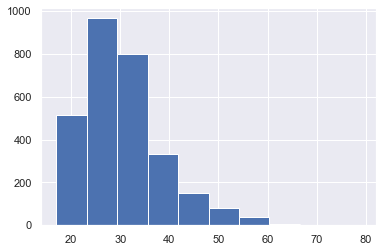

In [29]:
build_df['edad'].hist()

In [30]:
# Reemplazamos la variable "edad" por una categórica con "rangos de edad"
build_df['rango_edad'] = pd.qcut(clean_df['edad'], 4).astype(str)
build_df['rango_edad'].value_counts()

(16.999, 25.0]    852
(29.0, 34.0]      717
(34.0, 79.0]      697
(25.0, 29.0]      630
Name: rango_edad, dtype: int64

In [31]:
build_df = build_df.drop(columns=['edad'])

Esto lo hacemos dado que el comportamiento de endeudamiento cambia según la edad de las personas. Nótese el uso de pandas **qcut** para realizar este cálculo. Lo que hace es distribuir en categorías según los percentiles (Ver resultado de función *describe* anterior) y nos da una interpretación más general de la edad.

In [148]:
with open('data/age_ranges.pkl', 'wb') as f:
    pickle.dump(pd.qcut(clean_df['edad'], 4).unique().tolist(), f)

#### Variable antiguedad

Tenemos actualmente los siguientes valores categóricos:
- Menos de 6 meses
- de 6 meses a 1 año
- mas de 1 año

Vamos a reemplazar **de 6 meses a 1 año** y **mas de 1 año** por **6 meses o mas**

In [32]:
build_df['Antiguedad'].value_counts()

Menos de 6 meses      2393
de 6 meses a 1 año     484
mas de 1 año            19
Name: Antiguedad, dtype: int64

In [33]:
antiquity_map = {
    'Menos de 6 meses': 'Menos de 6 meses',
    'de 6 meses a 1 año': '6 meses o mas',
    'mas de 1 año': '6 meses o mas',
}
antiquity_map

{'Menos de 6 meses': 'Menos de 6 meses',
 'de 6 meses a 1 año': '6 meses o mas',
 'mas de 1 año': '6 meses o mas'}

In [34]:
build_df['Antiguedad'] = build_df['Antiguedad'].map(antiquity_map)
build_df['Antiguedad'].value_counts()

Menos de 6 meses    2393
6 meses o mas        503
Name: Antiguedad, dtype: int64

#### Variable MOP Historico

Los valores categóricos por los cuales se cambiaran son:
- Nulos: Sin registro
- N: Al día
- 1: Mora 30 días
- 2: Mora 60 días
- 3: Mora 90 días
- 4: Mora 120 días
- 5, 6: Mora > 120 días

In [35]:
build_df['mop_historico'].value_counts()

N    2282
6     359
4      34
5      18
2      13
3      11
1       4
Name: mop_historico, dtype: int64

In [36]:
mop_map = {
    'N': 'Al día',
    '1': 'Mora 30 días',
    '2': 'Mora 60 días',
    '3': 'Mora 90 días',
    '4': 'Mora 120 días',
    '5': 'Mora > 120 días',
    '6': 'Mora > 120 días',
}
mop_map

{'N': 'Al día',
 '1': 'Mora 30 días',
 '2': 'Mora 60 días',
 '3': 'Mora 90 días',
 '4': 'Mora 120 días',
 '5': 'Mora > 120 días',
 '6': 'Mora > 120 días'}

In [37]:
build_df['mop_historico'] = build_df['mop_historico'].map(mop_map)
build_df['mop_historico'] = build_df['mop_historico'].fillna('Sin registro')
build_df['mop_historico'].value_counts()

Al día             2282
Mora > 120 días     377
Sin registro        175
Mora 120 días        34
Mora 60 días         13
Mora 90 días         11
Mora 30 días          4
Name: mop_historico, dtype: int64

#### Variable perfil de usuario

Esta variable se calculará según el valor del **score**. A continuación se indican las transformaciones que se deben realizar a modo de rangos de score creditício:

- Nulos: Sin registro
- score = 1: Usuario en quiebra
- score = 7: Joven
- 150 <= score < 400: Bajo
- 400 <= score < 700: Medio
- 700 <= score < INF: Alto

[Referencia](https://qiip.com.co/es/blog/que-significa-tener-un-buen-puntaje-en-datacredito#:~:text=En%20Datacr%C3%A9dito%20el%20puntaje%20crediticio,de%20las%20obligaciones%20financieras%20pendientes)

<AxesSubplot:>

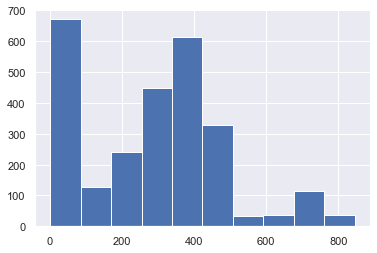

In [38]:
build_df['score'].hist()

In [39]:
def build_user_profile(value):
    if value == 1:
        return 'Usuario en quiebra'
    elif value == 7:
        return 'Joven'
    elif value >= 150 and value < 400:
        return 'Bajo'
    elif value >= 400 and value < 700:
        return 'Medio'
    elif value >= 700:
        return 'Alto'
    else:
        return 'Sin registro'
    
build_df['perfil_usuario'] = build_df['score'].apply(build_user_profile)
build_df['perfil_usuario'].value_counts()

Bajo                  1238
Usuario en quiebra     641
Medio                  613
Sin registro           246
Alto                   130
Joven                   28
Name: perfil_usuario, dtype: int64

In [40]:
build_df = build_df.drop(columns=['score'])

#### Variable Garantia

Vamos a convertir esta variable en catagoría así:

- 0: Sin garantia
- 1: Tipo garantia 1
- 2: Tipo garantia 2

In [41]:
build_df['Garantia'].value_counts()

2.0    2162
1.0     734
Name: Garantia, dtype: int64

In [42]:
garantia_map = {
    0.0: 'Sin garantia',
    1.0: 'Tipo garantia 1',
    2.0: 'Tipo garantia 2',
}
garantia_map

{0.0: 'Sin garantia', 1.0: 'Tipo garantia 1', 2.0: 'Tipo garantia 2'}

In [43]:
build_df['Garantia'] = build_df['Garantia'].map(garantia_map)
build_df['Garantia'] = build_df['Garantia'].fillna('Sin garantia')
build_df['Garantia'].value_counts()

Tipo garantia 2    2162
Tipo garantia 1     734
Name: Garantia, dtype: int64

### Verificación de los datos

In [44]:
len(target_column + categorical_columns + numerical_all_columns)

71

In [45]:
build_df.columns.shape[0]

71

Lo anterior verifica que la cantidad de variables previstas en los listados coincide con el listado del objeto pandas con los datos. La idea es tener control de las variables a través de las listas de python.

In [46]:
build_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Y                              2896 non-null   int64  
 1   genero                         2896 non-null   object 
 2   Antiguedad                     2896 non-null   object 
 3   Creditos                       2896 non-null   int64  
 4   saldo_actual                   2896 non-null   float64
 5   saldo_vencido                  2896 non-null   float64
 6   mop_historico                  2896 non-null   object 
 7   numero_pagos_vencidos          2896 non-null   float64
 8   Promedio de limite_credito     2896 non-null   float64
 9   Promedio de credito_maximo     2896 non-null   float64
 10  Promedio de cantidad_cuotas    2896 non-null   float64
 11  Promedio de valor_cuota        2896 non-null   float64
 12  ahorro_impacto                 2896 non-null   f

In [47]:
temp_df = pd.DataFrame(build_df.isna().sum()).reset_index()
temp_df.columns = ['column', 'is_null']
temp_df[temp_df.is_null > 0].size

0

Concluímos que todas las variables han sido categorizadas correctamente y se han imputado valores para una fase de modelado adecuada. A continuación, vamos a analizar relaciones entre las variables, se realizará un proceso de selección de características y balanceo de datos con especial enfasis en la variable objetivo.

## 3. Selección de características y balanceo de datos

In [48]:
select_df = build_df.copy()

### Homologación tipos de datos

Realizaremos un proceso donde vamos a separar variables categóricas (representadas por cadenas de caracteres), variables enteras de representación booleana (0 y 1), variables enteras discretas y variables flotantes continuas. Esta distinción se hace especialmente para estudiar relaciones entre las variables, buscando identificar aquellas que "posiblemente" no tengan relevancia en el modelado.

In [49]:
#boolean_columns = [
#    'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'Tiene_ahorro',
#    'Activos_garantia', 'Autos_garantia', 'Comunicaciones_garantia', 'consumo_garantia',
#    'Educacion_garantia', 'Libranza_garantia', 'microcredito_garantia', 'Otros_garantia',
#    'Tarjeta_garantia', 'Vivienda_garantia',
#]

type_numerical_columns = [
    'int64', 'float64', 'float64', 'int64', 'float64', 'float64', 'float64', 'float64', 
    'int64', 'int64', 'int64', 'int64', 'int64', 'float64', 'float64', 'float64',
]

type_numerical_groups_columns = [
    ['float64', 'float64', 'float64', 'int64', 'int64'],
    ['float64', 'float64', 'float64', 'int64', 'int64'],
    ['float64', 'float64', 'float64', 'int64', 'int64'],
    ['float64', 'float64', 'float64', 'int64', 'int64'],
    ['float64', 'float64', 'float64', 'int64', 'int64'],
    ['float64', 'float64', 'float64', 'int64'],
    ['float64', 'float64', 'float64', 'int64', 'int64'],
    ['float64', 'float64', 'float64', 'int64', 'int64'],
    ['float64', 'float64', 'float64', 'int64', 'int64'],
    ['float64', 'float64', 'int64']
]

In [50]:
for i, column in enumerate(numerical_columns):
    select_df[column] = \
        select_df[column].astype(type_numerical_columns[i])

for k, group in enumerate(numerical_groups_columns):
    for i, column in enumerate(group):
        select_df[column] = \
            select_df[column].astype(type_numerical_groups_columns[k][i])

select_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Y                              2896 non-null   int64  
 1   genero                         2896 non-null   object 
 2   Antiguedad                     2896 non-null   object 
 3   Creditos                       2896 non-null   int64  
 4   saldo_actual                   2896 non-null   float64
 5   saldo_vencido                  2896 non-null   float64
 6   mop_historico                  2896 non-null   object 
 7   numero_pagos_vencidos          2896 non-null   int64  
 8   Promedio de limite_credito     2896 non-null   float64
 9   Promedio de credito_maximo     2896 non-null   float64
 10  Promedio de cantidad_cuotas    2896 non-null   float64
 11  Promedio de valor_cuota        2896 non-null   float64
 12  ahorro_impacto                 2896 non-null   i

### Verificación características correlacionadas

Vamos a considerar que un valor de correlación **< 0.75** o **> 0.75**, usando el método de Pearson, permite filtrar las columnas con una posible relación significativa y por tanto, esas variables serán consideradas en una validación posterior usando *p-value* (valor de significancia o relevancia de la relación).

In [51]:
lower_threshold, upper_threshold = -0.75, 0.75

In [52]:
numerical_corr_columns = []

for i, r in select_df[numerical_all_columns].corr(method='pearson').reset_index().iterrows():
    for c in numerical_all_columns:
        if c != r['index'] and (r[c] < lower_threshold or r[c] > upper_threshold):
            if c not in numerical_corr_columns:
                numerical_corr_columns.append(c)
            
len(numerical_corr_columns)

27

<AxesSubplot:>

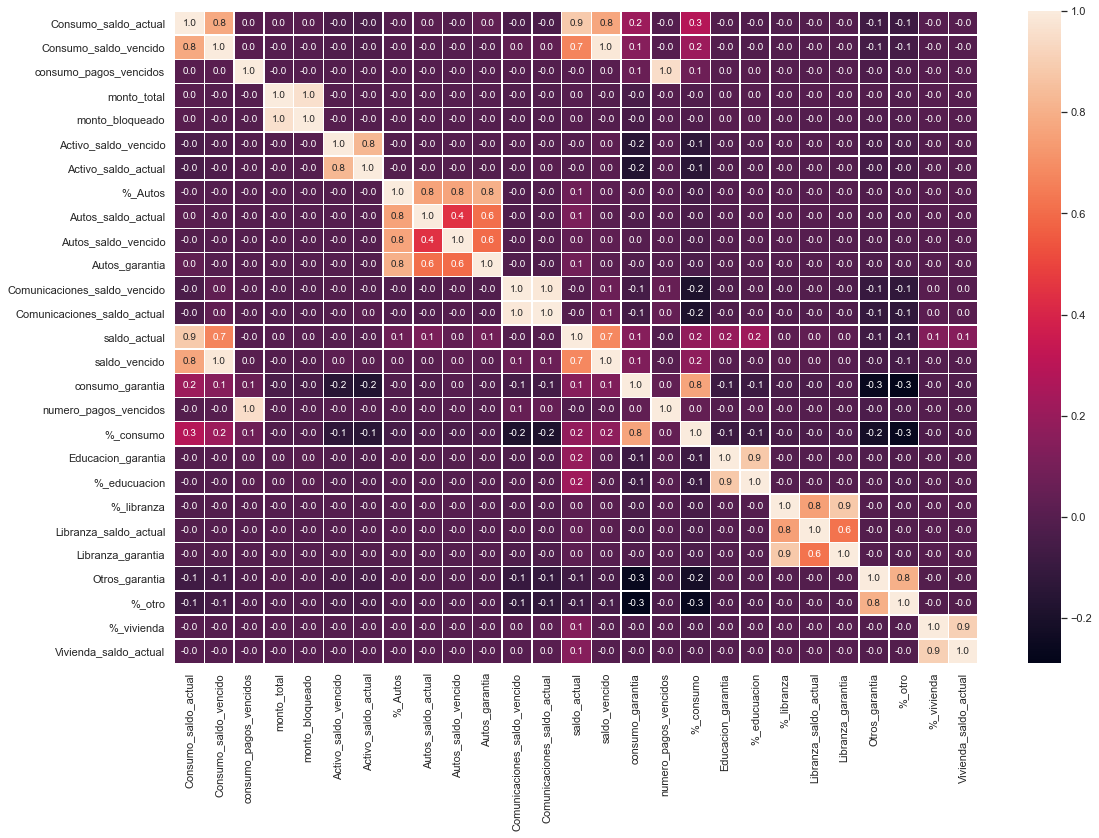

In [53]:
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(select_df[numerical_corr_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Dado el mapa de calor anterior, logramos identificar características que tienen correlaciones fuertes, es decir, sospechamos que tengan una relación pero no confirmada. En este punto, vamos a estudiar las distribuciones por grupos de variables y trataremos de comprender estadisticamente si realmente algunas de las variables las podemos descartar dado que tienen una relación significativa.

In [54]:
numerical_corr_columns = []

for i, r in select_df[numerical_all_columns].corr(method='pearson').reset_index().iterrows():
    for c in numerical_all_columns:
        if c != r['index'] and (r[c] < lower_threshold or r[c] > upper_threshold):
            if c not in [k['column'] for k in numerical_corr_columns] \
                and (r['index'], c) not in [(k['index'], k['column']) for k in numerical_corr_columns] \
                and (r['index'], c) not in [(k['column'], k['index']) for k in numerical_corr_columns]:
                numerical_corr_columns.append({
                    "index": r['index'], "column": c, "value": r[c]
                })
            
corr2_df = pd.DataFrame(numerical_corr_columns)
corr2_df

index                        column     value
0                  saldo_actual          Consumo_saldo_actual  0.888338
1                 saldo_vencido         Consumo_saldo_vencido  0.986894
2         numero_pagos_vencidos        consumo_pagos_vencidos  0.953271
3               monto_bloqueado                   monto_total  0.960200
4           Activo_saldo_actual          Activo_saldo_vencido  0.825660
5            Autos_saldo_actual                       %_Autos  0.761809
6                       %_Autos           Autos_saldo_vencido  0.767572
7                       %_Autos                Autos_garantia  0.802868
8   Comunicaciones_saldo_actual  Comunicaciones_saldo_vencido  0.988811
9          Consumo_saldo_actual                 saldo_vencido  0.769491
10                    %_consumo              consumo_garantia  0.764534
11                 %_educuacion            Educacion_garantia  0.879892
12        Libranza_saldo_actual                    %_libranza  0.750338
13                   %_libranza             Libranza_garantia  0.881975
14                       %_otro                Otros_garantia  0.800342
15        Vivienda_saldo_actual                    %_vivienda  0.909174

Como podemos notar en la tabla, existen variables que por su fuerte correlación amerita realizar un estudio más a fondo y verificar si existe o no una relación. Para lograr esto, buscamos que el **p-value** sea menor que **0.05**, en ese caso se concluye que la relación es estadísticamente significativa.

In [55]:
def pearson_and_pvalue(list1, list2):
    pearson, pvalue = pearsonr(list1, list2)
    return round(pearson, 2), round(pvalue, 6)

corr2_df['complete'] = corr2_df.apply(
    lambda r: pearson_and_pvalue(select_df[r["index"]], select_df[r["column"]]), 
    axis=1
)
corr2_df

index                        column     value  \
0                  saldo_actual          Consumo_saldo_actual  0.888338   
1                 saldo_vencido         Consumo_saldo_vencido  0.986894   
2         numero_pagos_vencidos        consumo_pagos_vencidos  0.953271   
3               monto_bloqueado                   monto_total  0.960200   
4           Activo_saldo_actual          Activo_saldo_vencido  0.825660   
5            Autos_saldo_actual                       %_Autos  0.761809   
6                       %_Autos           Autos_saldo_vencido  0.767572   
7                       %_Autos                Autos_garantia  0.802868   
8   Comunicaciones_saldo_actual  Comunicaciones_saldo_vencido  0.988811   
9          Consumo_saldo_actual                 saldo_vencido  0.769491   
10                    %_consumo              consumo_garantia  0.764534   
11                 %_educuacion            Educacion_garantia  0.879892   
12        Libranza_saldo_actual                    %_libranza  0.750338   
13                   %_libranza             Libranza_garantia  0.881975   
14                       %_otro                Otros_garantia  0.800342   
15        Vivienda_saldo_actual                    %_vivienda  0.909174   

       complete  
0   (0.89, 0.0)  
1   (0.99, 0.0)  
2   (0.95, 0.0)  
3   (0.96, 0.0)  
4   (0.83, 0.0)  
5   (0.76, 0.0)  
6   (0.77, 0.0)  
7    (0.8, 0.0)  
8   (0.99, 0.0)  
9   (0.77, 0.0)  
10  (0.76, 0.0)  
11  (0.88, 0.0)  
12  (0.75, 0.0)  
13  (0.88, 0.0)  
14   (0.8, 0.0)  
15  (0.91, 0.0)

Lo anterior indica que todas las relaciones estudiadas tienen un **p-value** por debajo del **0.05** y por tanto, todas son estadísticamente significativas. Vamos a seleccionar aquellas variables que por concepto de negocio realmente podrían ser descartadas del modelado, más por su significancia en negocio que de forma numérica.

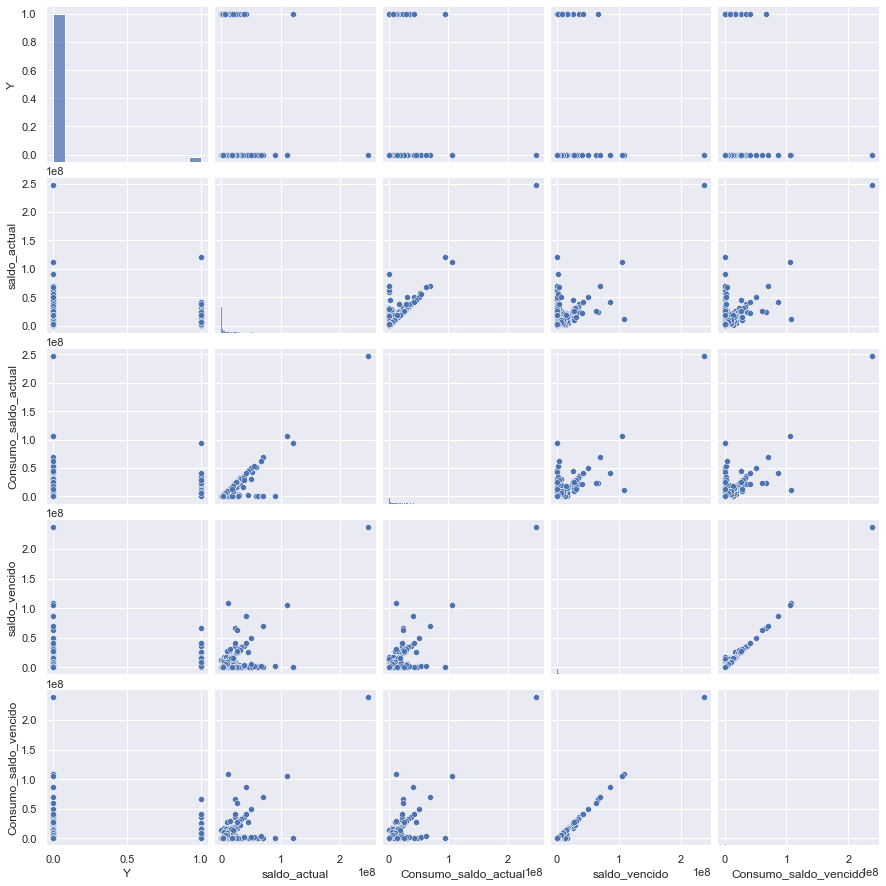

In [56]:
sns.pairplot(select_df[target_column + ['saldo_actual', 'Consumo_saldo_actual', 'saldo_vencido', 'Consumo_saldo_vencido']])

**saldo_actual vs. Consumo_saldo_actual:** Vemos que la distribución marca una clara tendencia en ambas variables, pero se notan algunos factores de dispersión que hace sospechar que su relación no sea tan fuerte desde negocio y que algunos valores salgan de la tendencia lineal. Se conservarán ambas variables.

**saldo_vencido vs. Consumo_saldo_vencido:** En este caso, vamos a descartar la variable saldo_vencido, precisamente al ver que la distribución de los datos muestra un comportamiento en tendencia lineal. Concluímos que la variable Consumo_saldo_vencido explica perfectamente el comportamiento de saldo_vencido.

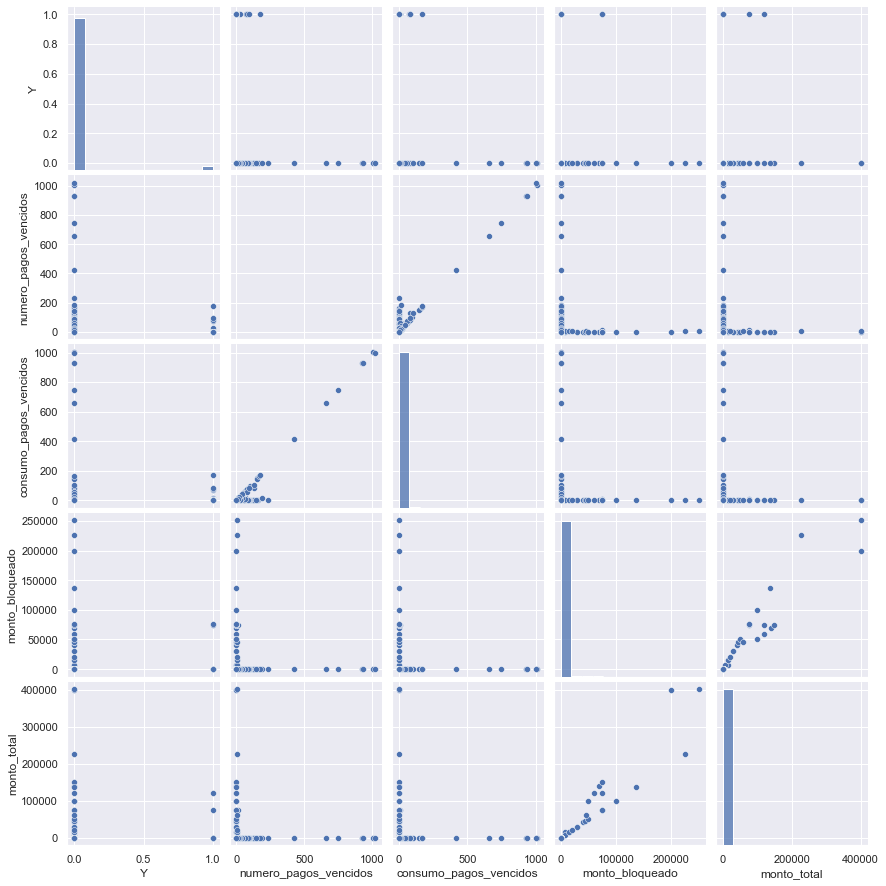

In [57]:
sns.pairplot(select_df[target_column + ['numero_pagos_vencidos', 'consumo_pagos_vencidos', 'monto_bloqueado', 'monto_total']])

**numero_pagos_vencidos vs. consumo_pagos_vencidos:** Note que tenemos una variable discreta y la otra continua con una relación bastante fuerte de 95%. Nos quedaremos por tanto con la variable continua, ya que puede aportar más valor en el modelado.

**monto_bloqueado vs. monto_total:** Se nota una fuerte tendencia lineal y por tanto, dado que también cuentan con un valor de correlación muy alto del 96%, eliminamos en este caso la variable monto_bloqueado y dejamos monto_total que explica perfectamente el comportamiento de ambas.

**NOTA:** El resto de variables que se estudiarion para eliminar por correlaciones no será considerado, ya que dichas características corresponden a las variables que vienen en bloque y con una fuerte relación con los productos adquiridos por el usuario, por tanto, se decide no tocarlas para el proceso de modelado.

In [58]:
select_df = select_df.drop(columns=[
    'saldo_vencido', 'numero_pagos_vencidos', 'monto_bloqueado', 
])

select_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 68 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Y                              2896 non-null   int64  
 1   genero                         2896 non-null   object 
 2   Antiguedad                     2896 non-null   object 
 3   Creditos                       2896 non-null   int64  
 4   saldo_actual                   2896 non-null   float64
 5   mop_historico                  2896 non-null   object 
 6   Promedio de limite_credito     2896 non-null   float64
 7   Promedio de credito_maximo     2896 non-null   float64
 8   Promedio de cantidad_cuotas    2896 non-null   float64
 9   Promedio de valor_cuota        2896 non-null   float64
 10  ahorro_impacto                 2896 non-null   int64  
 11  bienestar_financiero_impacto   2896 non-null   int64  
 12  coaching_impacto               2896 non-null   i

### Construcción de variables dummy (categóricas a matriz dispersa)

En este proceso vamos a convertir las variables categóricas en características dummy, es decir, las vamos a transformar en una matriz dispera de ceros y unos, donde cada valor se convierte en una columna con un indicador 0 o 1. Esto se realizará para poder ejecutar modelos, ya que estos algorítmos no comprender las variables de este tipo.

In [59]:
select2_df = select_df.copy()

In [60]:
select2_df = pd.get_dummies(select2_df, columns=categorical_columns)
select2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 89 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Y                                  2896 non-null   int64  
 1   Creditos                           2896 non-null   int64  
 2   saldo_actual                       2896 non-null   float64
 3   Promedio de limite_credito         2896 non-null   float64
 4   Promedio de credito_maximo         2896 non-null   float64
 5   Promedio de cantidad_cuotas        2896 non-null   float64
 6   Promedio de valor_cuota            2896 non-null   float64
 7   ahorro_impacto                     2896 non-null   int64  
 8   bienestar_financiero_impacto       2896 non-null   int64  
 9   coaching_impacto                   2896 non-null   int64  
 10  Desinstalaciones                   2896 non-null   int64  
 11  Tiene_ahorro                       2896 non-null   int64

In [61]:
print(target_column)

['Y']


In [62]:
features_columns = select2_df.columns.tolist()[1:]
print(features_columns)

['Creditos', 'saldo_actual', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'Desinstalaciones', 'Tiene_ahorro', 'monto_ahorro', 'monto_total', 'Activo_saldo_actual', 'Activo_saldo_vencido', '%_Activo', 'Activos_pagos_vencidos', 'Activos_garantia', 'Autos_saldo_actual', 'Autos_saldo_vencido', '%_Autos', 'Autos_pagos_vencidos', 'Autos_garantia', 'Comunicaciones_saldo_actual', 'Comunicaciones_saldo_vencido', '%_comunicaciones', 'Comunicaciones_pagos_vencidos', 'Comunicaciones_garantia', 'Consumo_saldo_actual', 'Consumo_saldo_vencido', '%_consumo', 'consumo_pagos_vencidos', 'consumo_garantia', 'Educacion_saldo_actual', 'Educacion_saldo_vencido', '%_educuacion', 'Educacion_pagos_vencidos', 'Educacion_garantia', 'Libranza_saldo_actual', 'Libranza_saldo_vencido', '%_libranza', 'Libranza_garantia', 'Microcredito_saldo_actual', 'Microcredito_saldo_vencido'

In [63]:
len(features_columns)

88

### Selección de características relevantes

A continuación realizaremos un par de procesos que nos permitirán intuir que variables son más relevantes para el modelado. Por un lado, vamos a ejecutar una **eliminación recursiva de características** con el fin de descartar aquellas variables que aportan poco al modelo. En segundo lugar, intentaremos con una **eliminación por importancia** usando un modelo de Árboles de decisión, clasificando las variables según su influencia en el modelado.

In [64]:
X, y = select2_df[features_columns], select2_df[target_column]

#### Eliminación recursiva de características

Utilizando un procedimiento de modelado inicial con **Regresión Logística**, vamos a seleccionar las variables más importantes del conjunto de datos realizando una **eliminación recursiva** hasta dejar una cantidad de variables que tengan un aporte realmente significativo.

In [65]:
def get_rfe_analysis(X, y, feature_list):
    score_list, support_list = [], []
    for n_features in feature_list:
        model = LogisticRegression(random_state=0)
        selector = RFE(estimator=model, n_features_to_select=n_features)
        selector.fit(X, y)
        score_list.append(selector.score(X, y))
        support_list.append(selector.support_)
    result_dict = {
        "label": feature_list,
        "score": score_list,
        "support": support_list,
    }
    return pd.DataFrame(result_dict)

<AxesSubplot:xlabel='label', ylabel='score'>

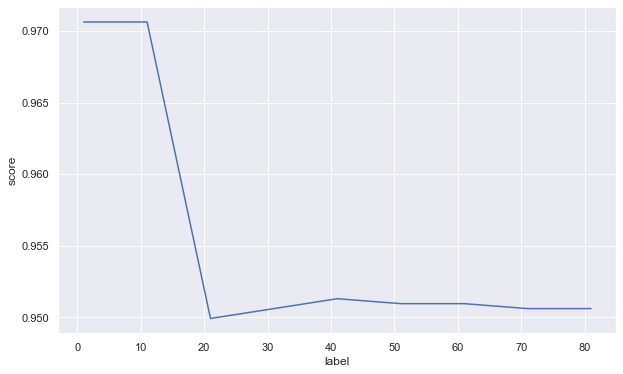

In [66]:
result_1 = get_rfe_analysis(X, y, feature_list=list(range(1, len(features_columns)+1, 10)))

f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=result_1, x='label', y='score', ax=ax)

Tal parece que de 20 variables en adelante el **score** de entrenamiento se estabiliza un poco en **95%**. Considerando esto, a seleccionar la mejor cantidad de variables en el rango 55 a 65 caracteristicas, dado que en este se presenta un pico.

<AxesSubplot:xlabel='label', ylabel='score'>

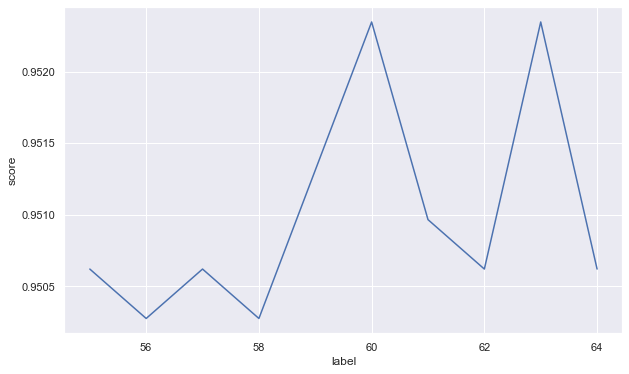

In [67]:
result_2 = get_rfe_analysis(X, y, feature_list=list(range(55, 65, 1)))

f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=result_2, x='label', y='score', ax=ax)

De lo anterior concluímos lo siguiente: Al realizar una **eliminación recursiva de características** encontramos que el **score** de entrenamiento se estabiliza a partir de **20 características** y en **58 y 61 variables** se obtiene el mejor score de entrenamiento para este rango. El hiper parámetro **cantidad de características a seleccionar** que se decide poner es **58 variables**.

In [68]:
result_final = get_rfe_analysis(X, y, feature_list=[58])
support_list = result_final.support.tolist()[0]

len(support_list)

88

In [69]:
column_list = X.columns.tolist()
len(column_list)

88

In [70]:
rfe_columns = [column for i, column in enumerate(column_list) if support_list[i]]
len(rfe_columns)

58

In [71]:
print(rfe_columns)

['Creditos', 'saldo_actual', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'Desinstalaciones', 'monto_ahorro', 'monto_total', 'Activo_saldo_actual', 'Activo_saldo_vencido', 'Activos_garantia', 'Autos_saldo_actual', 'Autos_saldo_vencido', 'Comunicaciones_saldo_actual', 'Comunicaciones_saldo_vencido', '%_comunicaciones', 'Comunicaciones_pagos_vencidos', 'Comunicaciones_garantia', 'Consumo_saldo_actual', 'Consumo_saldo_vencido', '%_consumo', 'consumo_pagos_vencidos', 'consumo_garantia', 'Educacion_saldo_actual', 'Educacion_saldo_vencido', 'Libranza_saldo_actual', 'Libranza_saldo_vencido', 'Microcredito_saldo_actual', 'Microcredito_saldo_vencido', 'microcredito_garantia', 'Otros_saldo_actual', 'Otros_saldo_vencido', 'Otros_garantia', 'Tarjeta_credito_saldo_actual', 'Tarjeta_credito_saldo_vencido', '%_tarjeta', 'Tarjeta_pagos_vencidos', 'Vivienda_saldo_actual', 'genero_FEMENINO', 'genero_MASCULINO', 'rango_edad_(16.999,

### Eliminación de características por importancia

De manera completaria, vamos a realizar un proceso de **eliminación de variables usando un modelo de Ensemble**, en este caso **Random Forest**, para encontrar características que sean mucho más significativas para el modelado. Nuestro objetivo es tratar de dejar solo el 50% de las variables con dos finalidades: la primera es evitar sobreajustes en el modelado y la segunda es para volver más eficiente, computacionalmente, el modelamiento.

In [72]:
model_ = RandomForestClassifier()
model_.fit(X, y)

feature_names = np.array(X.columns)

pd.Series(model_.feature_importances_ * 1000).describe()

count    88.000000
mean     11.363636
std      18.744583
min       0.000000
25%       0.600452
50%       3.889896
75%      10.260696
max      84.236909
dtype: float64

<AxesSubplot:>

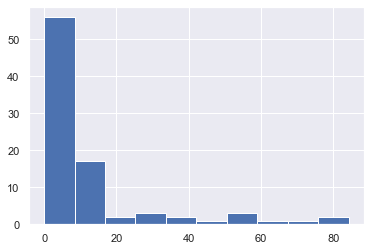

In [73]:
pd.Series(model_.feature_importances_ * 1000).hist()

A partir del percentil **50% (mediana)** se comienzan a apreciar los valores de importancia más altos y significativos con respecto a los percentiles por debajo de este. En comparación con la **media** que es más alta, dada la variabilidad de la distribución y la asimetría que presenta, con una cola pesada a la derecha, es mejor decisión utilizar la mediana como medida de tendencia central. Usaremos esta métrica para configurar el algoritmo de **selección de características**.

In [74]:
selector = SelectFromModel(model_, threshold='median')
selector.fit(X, y)

len(feature_names[selector.get_support()])

44

In [75]:
ife_columns = feature_names[selector.get_support()]
print(ife_columns)

['Creditos' 'saldo_actual' 'Promedio de limite_credito'
 'Promedio de credito_maximo' 'Promedio de cantidad_cuotas'
 'Promedio de valor_cuota' 'coaching_impacto' 'Desinstalaciones'
 'Tiene_ahorro' 'monto_ahorro' 'Comunicaciones_saldo_actual'
 'Comunicaciones_saldo_vencido' '%_comunicaciones'
 'Comunicaciones_garantia' 'Consumo_saldo_actual' 'Consumo_saldo_vencido'
 '%_consumo' 'consumo_pagos_vencidos' 'consumo_garantia'
 'Microcredito_saldo_actual' 'microcredito_garantia'
 'Tarjeta_credito_saldo_actual' 'Tarjeta_credito_saldo_vencido'
 '%_tarjeta' 'Tarjeta_garantia' 'genero_DESCONOCIDO' 'genero_FEMENINO'
 'genero_MASCULINO' 'rango_edad_(16.999, 25.0]' 'rango_edad_(25.0, 29.0]'
 'rango_edad_(29.0, 34.0]' 'rango_edad_(34.0, 79.0]'
 'Antiguedad_Menos de 6 meses' 'mop_historico_Al día'
 'mop_historico_Mora > 120 días' 'perfil_usuario_Alto'
 'perfil_usuario_Bajo' 'perfil_usuario_Medio'
 'perfil_usuario_Sin registro' 'perfil_usuario_Usuario en quiebra'
 'sistema_operativo_ANDROID' 'sistema_o

En conclusión, luego de todo el proceso de **selección de características**, se decide utilizar el método de **eliminación por importancia** realizado con el modelo RandomForest y SelectFromModel que nos deja las **44 variables** con mayor nivel de importancia.

In [76]:
select_final_df = select2_df[ife_columns]
select_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditos                           2896 non-null   int64  
 1   saldo_actual                       2896 non-null   float64
 2   Promedio de limite_credito         2896 non-null   float64
 3   Promedio de credito_maximo         2896 non-null   float64
 4   Promedio de cantidad_cuotas        2896 non-null   float64
 5   Promedio de valor_cuota            2896 non-null   float64
 6   coaching_impacto                   2896 non-null   int64  
 7   Desinstalaciones                   2896 non-null   int64  
 8   Tiene_ahorro                       2896 non-null   int64  
 9   monto_ahorro                       2896 non-null   float64
 10  Comunicaciones_saldo_actual        2896 non-null   float64
 11  Comunicaciones_saldo_vencido       2896 non-null   float

In [144]:
with open('data/columns.pkl', 'wb') as f:
    pickle.dump(ife_columns, f)

In [159]:
# Repisamos el valor de la X original
X = select_final_df

### Balanceo datos en variable objetivo

In [160]:
y.Y.value_counts() / y.shape[0]

0    0.970649
1    0.029351
Name: Y, dtype: float64

<AxesSubplot:xlabel='Y', ylabel='count'>

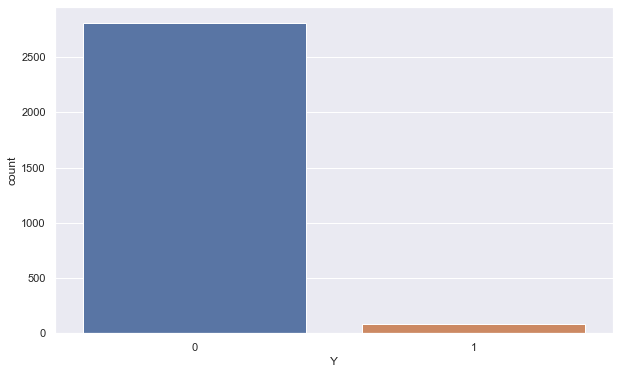

In [180]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x=y.Y, ax=ax)

Como se puede apreciar, hay un desbalance notable entre las personas que fueron **Aceptadas** y **Rechazadas**. Los aceptados apenas suman el 3% de la población. Dado lo anterior, vamos a buscar una forma de adecuada de balancear los datos para el proceso de entrenamiento sin desmejorar las condiciones del mismo, dado que un estimador para la clase **Aceptadas** es probable que no funcione bien o no prediga bien una observación nueva.

Iniciaremos entonces a estudiar algunas alternativas de balanceo de nuestra variable objetivo hasta determinar la mejor opción de modelado, es decir, los mejores parámetros para un modelado confiable y con alta precisión en nuestra muestra desbalanceada. Propongo las siguientes dos técnicas:

* **Ajustando parámetros de pesos de los modelos de clasificación**, por ejemplo, la regresión logística cumple este propósito y permite balancear con estos parámetros.

* **Ensamble de métodos balanceados** que utiliza las ventajas de los modelos tipo Ensemble para entrenar y luego decide por "votación" el resultado final, usando al mismo tiempo estrategías de balanceo de clases.

**NOTA:** Otra alternativa es **modificar el conjunto de datos y equilibrar las clases**, pero esto es peligroso dado que los datos de la clase minoritaria son muy pocos y estaremos eliminando muestras importantes para el entrenamiento. Por otro lado, podemos aplicar **generación de muestras artificiales o sintéticas**, pero en este caso, y dado que la clase minoritaria es tan insuficiente, podemos alterar demasiado la distribución de los datos al tratar de aumentar tanto una de las clases, considerando que no queremos sacrificar datos de la clase mayoritaría.

In [162]:
# Nombres de las clases
LABELS = ["rejected", "accepted"]

# Hacemos un split datos de entrenamiento y pruebas
# Dejamos 70% para entrenar y 30% para pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2027, 44), (869, 44), (2027, 1), (869, 1))

In [163]:
def run_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    pred_y = model.predict(X_test)
    return model, pred_y

def show_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(y_test, pred_y))

#### Modelado inicial sin balanceo de datos

Vamos a ejecutar un modelado inicial antes de la aplicación de técnicas de balanceo de datos para analizar los resultados, especialmente en la clase desbalanceada.

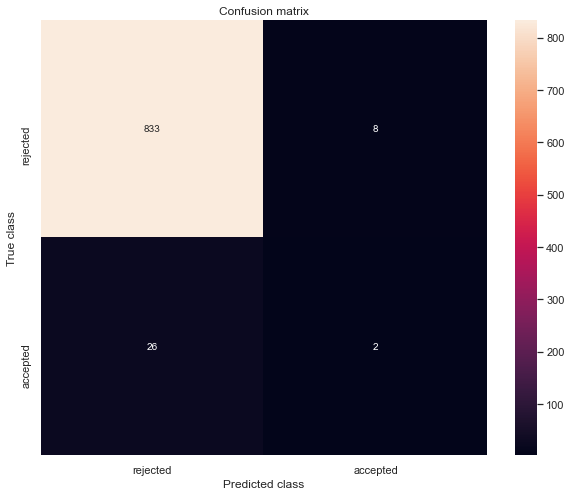

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       841
           1       0.20      0.07      0.11        28

    accuracy                           0.96       869
   macro avg       0.58      0.53      0.54       869
weighted avg       0.94      0.96      0.95       869



In [164]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    LogisticRegression(random_state=1, solver='liblinear'))

show_results(y_test, pred_y)

Podemos apreciar que para la clase **Aceptado** tenemos 26 fallos y 2 aciertos lo cual nos da un **recall** muy bajo de **7%**. Aunque la precisión y el recall para la predicción de **Rechazado** es bastante buena, debemos mejorar el valor obtenido para la otra clase que es nuestro foco en los siguientes apartados.

#### Ajustando parámetros "peso de clase" en los modelos

Para esta práctica vamos a utilizar dos modelos de clasificación: **Logistic Regression** y **Random Forest**. El objetivo es **ajustar los parámetros de pesos en las clases** y verificar el ajuste del modelo a estos. En caso que alguno de los parámetros logre un ajuste confiable, se decidirá por éste hasta validar otras técnicas.

#### Logistic Regression

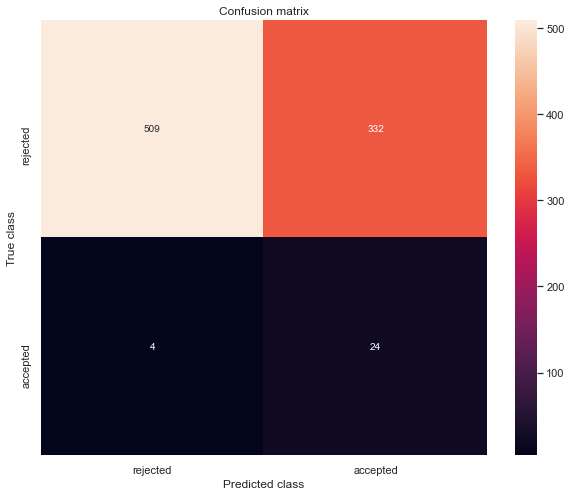

              precision    recall  f1-score   support

           0       0.99      0.61      0.75       841
           1       0.07      0.86      0.12        28

    accuracy                           0.61       869
   macro avg       0.53      0.73      0.44       869
weighted avg       0.96      0.61      0.73       869



In [165]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    LogisticRegression(random_state=1, solver='liblinear', class_weight="balanced"))

show_results(y_test, pred_y)

#### Random Forest

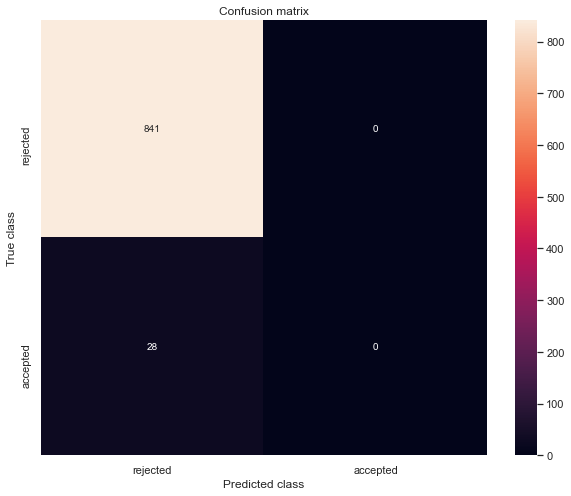

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       841
           1       0.00      0.00      0.00        28

    accuracy                           0.97       869
   macro avg       0.48      0.50      0.49       869
weighted avg       0.94      0.97      0.95       869



In [166]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    RandomForestClassifier(random_state=1, class_weight="balanced"))

show_results(y_test, pred_y)

La conclusión a la que podemos llegar es que con el modelo de **Regresion Logística**, solo con adicionar el parámetro de balanceo de pesos en las clases, obtenemos una mejor respuesta para predicir la clase **Aceptado** con un valor de **recall** de **86%**. Se puede notar que desmejora la calidad de recall para la clase **Rechazado**, pero nos permite **ser más robusto para predecir cuando Aceptar un usuario en el proceso**.

El modelo **Random Forest** no permite tener un acercamiento adecuado a una mejora del recall para la clase desbalanceada, pero se tendrá en cuenta para la siguiente estrategia de "votación".

#### Ensamble de métodos balanceados

En este caso vamos a utilizar el modelo **Balanced Bagging** de la librería **imbalanced learn** el cual nos ofrece una abstracción bastante profunda de un modelo basado en "votación" en conjunto con una balanceo de las clases.

#### Logistic Regression

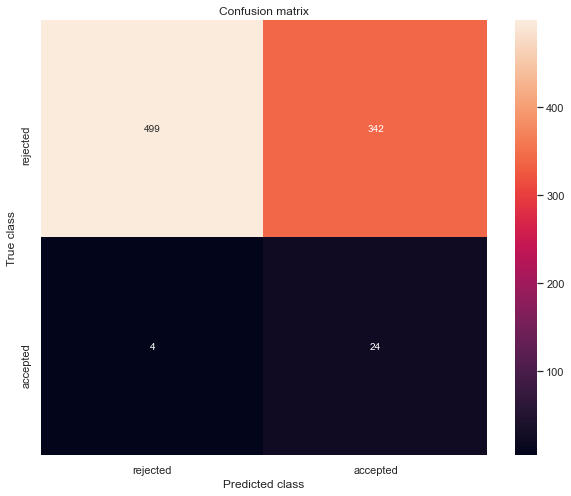

              precision    recall  f1-score   support

           0       0.99      0.59      0.74       841
           1       0.07      0.86      0.12        28

    accuracy                           0.60       869
   macro avg       0.53      0.73      0.43       869
weighted avg       0.96      0.60      0.72       869



In [167]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=LogisticRegression(random_state=1, solver='liblinear'), 
        sampling_strategy='auto', replacement=False, random_state=0))

show_results(y_test, pred_y)

#### Random Forest

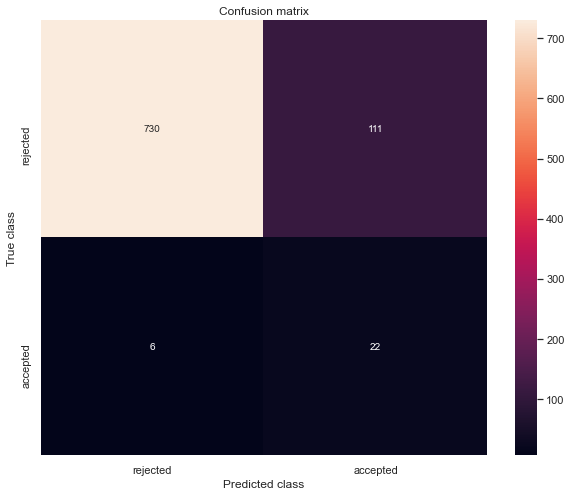

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       841
           1       0.17      0.79      0.27        28

    accuracy                           0.87       869
   macro avg       0.58      0.83      0.60       869
weighted avg       0.97      0.87      0.90       869



In [168]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=RandomForestClassifier(random_state=1), 
        sampling_strategy='auto', replacement=False, random_state=0))

show_results(y_test, pred_y)

En general, ambos resultados son bastante buenos. Sorprendentemente, el modelo de Bagging usando Logistic Regression ha logrado aumentar el **recall** de la clase **Aceptado** a **86%**, con 4 fallos y 24 aciertos.

**NOTA:** La conclusión final es utilizar el modelo de **BalancedBaggingClassifier** con ambos métodos, la **regresión logística** y **random forest**, pero lo que haremos es realizar un modelado de clasificación con optimización de hiper-parámetros, buscando mejorar el valor de recall en cada iteración.

In [169]:
param_grid_bagging = [{
    'n_estimators': [50, 100], 
    'sampling_strategy': ['auto', 'not majority'], 
    'replacement': [False, True],
}]

def run_model_selector(X_train, X_test, y_train, y_test, model, param_grid):
    clf = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring=make_scorer(recall_score))
    clf.fit(X_train, y_train)
    pred_y = clf.best_estimator_.predict(X_test)
    return clf.best_estimator_, pred_y

## 4. Modelamiento con Regresión Logística

Lo primero a realizar es un ajuste de hiper-parámetros para la Regresión Logística. **Seleccionamos el mejor modelo y lo ingresamos en el Clasificación de Bagging con un ajuste de hiper-parámetros** adicional para obtener finalmente un modelo robusto de clasificación.

In [170]:
param_grid_lr = [{
    'penalty': ['l1', 'l2'], 
    'C': [0.1, 0.5, 1.0], 
    'solver': ['liblinear', 'newton-cg'],
}]

model_lr, pred_y_lr = run_model_selector(
    X_train, X_test, y_train, y_test, 
    LogisticRegression(random_state=1),
    param_grid_lr)

print(f"Best model: {model_lr}")

Best model: LogisticRegression(C=0.1, random_state=1, solver='liblinear')


In [171]:
# show_results(y_test, pred_y_lr)

In [172]:
model_lr_bg, pred_y_lr_bg = run_model_selector(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=model_lr, 
        random_state=0),
    param_grid_bagging)

print(f"Best model: {model_lr_bg}")

Best model: BalancedBaggingClassifier(base_estimator=LogisticRegression(C=0.1,
                                                            random_state=1,
                                                            solver='liblinear'),
                          n_estimators=100, random_state=0)


## 5. Modelamiento con Random Forest

Realizamos un ajuste de hiper-parámetros para la Random Forest. **Seleccionamos el mejor modelo y lo ingresamos en el Clasificador de Bagging con un ajuste de hiper-parámetros** adicional para obtener finalmente un modelo robusto de clasificación.

In [173]:
param_grid_rf = [{
    'criterion': ['gini', 'entropy'], 
    'n_estimators': [100, 200], 
    'bootstrap': [False, True],
}]

model_rf, pred_y_rf = run_model_selector(
    X_train, X_test, y_train, y_test, 
    RandomForestClassifier(random_state=1),
    param_grid_rf)

print(f"Best model: {model_rf}")

Best model: RandomForestClassifier(bootstrap=False, random_state=1)


In [174]:
# show_results(y_test, pred_y_rf)

In [175]:
model_rf_bg, pred_y_rf_bg = run_model_selector(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=model_rf, 
        random_state=0),
    param_grid)

print(f"Best model: {model_rf_bg}")

Best model: BalancedBaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                                random_state=1),
                          n_estimators=50, random_state=0)


## 6. Definición y justificación de la mejor métrica

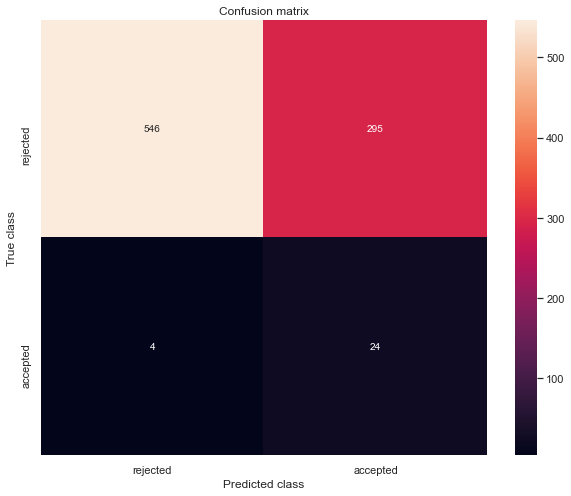

              precision    recall  f1-score   support

           0       0.99      0.65      0.79       841
           1       0.08      0.86      0.14        28

    accuracy                           0.66       869
   macro avg       0.53      0.75      0.46       869
weighted avg       0.96      0.66      0.76       869



In [176]:
show_results(y_test, pred_y_lr_bg)

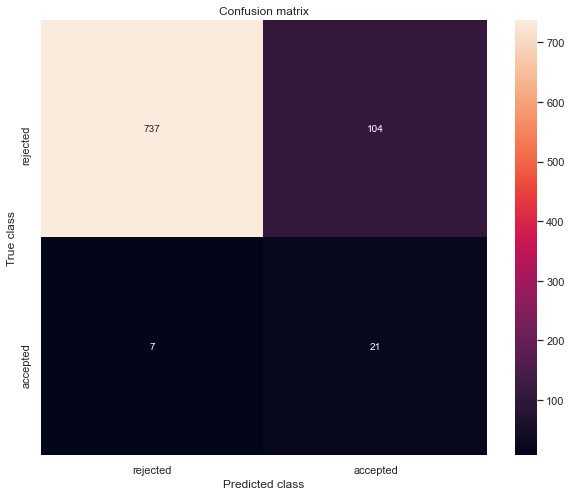

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       841
           1       0.17      0.75      0.27        28

    accuracy                           0.87       869
   macro avg       0.58      0.81      0.60       869
weighted avg       0.96      0.87      0.91       869



In [177]:
show_results(y_test, pred_y_rf_bg)

El modelo ejecutado con optimización de hiper-parámetros usando **Regresión Logística** con el algoritmo de "votación" **Bagging Classifier** es el que permite obtener un mejor resultado general. El valor de *Accuracy* es de 66%, no es precisamente robusto en términos generales.

Para la clase **Rechazado** encontramos un *Precision* de 99% y un *Recall* de 65%, lo cual indica que es suficientemente robusto para descartar usuarios que no cumplen con los criterios para ingresar en el programa de reparación de deuda.

Para la clase **Aceptado** encontramos un *Precision* de 8% y un *Recall* de 86%. La primera métrica nos indica que no es un modelo confiable para predecir esta clase, sin embargo, el valor de recall permite intuir que para casos donde se requiere predecir un usuario como *Aceptado*, tiene la suficiente calidad para encontrarlo.

In [178]:
# Almacenamos el modelo en un archivo pickle
with open('data/model.pkl', 'wb') as f:
    pickle.dump(model_lr_bg, f)